# Medical Predictions - Birmingham Artificial Intelligence Meetup - Code Walk-Through


The information, documentation and software are intended to convey best Machine Learning Work Practices.   The software provided is for demonstration purposes only,  and is an educational aid.    Use of this software by you or a third party is entirely at your own risk. 


In [1]:
########################################################################################################
# WorkFlow based on machine learning mastery (https://machinelearningmastery.com/) by Jason BrownLee.
# Excellent Tutorial here https://towardsdatascience.com/building-a-simple-machine-learning-model
# -on-breast-cancer-data-eca4b3b99fa3 
# Modified for  medical device applications considering regulatory process by Geoff Spence and Vince Hall. 
########################################################################################################

# Guidelines 
# Training and validation on data must be clinically meaningful
# Independent blinded evaluation on validation data
# Applications must generalise to wider population
# Consistent means of measuring performance of algorithms

# Machine Learning workflow

# Step 1. Define Problem: Investigate and characterize the problem in order to better understand
# the goals of the project.
# a) how many patients do we have ? - sample size
# b) how many classes do we have ?  - Benign or malignant 
# c) how many features do we have ? 
# d) do we have a class imbalance ? - prevalence of the disease 
# e) Training / Validation Spilt (Training and testing on data that is clinically meaningful)
# f) measure of performance - accuracy ? ROC (AUC) 
# g) final outcome - specificity reported against a 98% sensitivity level  ?
# h) 10-15 patient samples required per feature

# Step 2. Analyze Data: Use descriptive statistics and visualization to better understand the data
# you have available.
# check correlation of features 
# check skewness of features 
# check for outliers 
# check for missing values 
# check features for mean, median, percentiles 
# visualise distribution of the features
# visualise distribution of the features (by class)
# visualise outliers (box plot)
# visualise correlation 
# visualise pairwise scatterplot

# Step 3. Prepare Data: Use data transforms in order to better expose the structure of the
# prediction problem to modeling algorithms.

# Train Validation Spilt 
# on training data only 
# standardisation
# select important features (dimensionality reduction) 
# transform features to a Gaussian distribution?
# remove correlated features 

# Step 4. Evaluate Algorithms: Design a test harness to evaluate a number of standard algorithms
# on the data and select the top few to investigate further.
# on training data only 
# LR, LDA, QDA, KNN, CART, NB, SVM, MLP

# metric ROC (auc) 
# k fold - cross-validation 
# Confidence intervals 

# Step 5. Improve Results: Use most promising methods from stage 4.  Use algorithm tuning, hyperparameter selection and 
# ensemble methods to get the most out of well-performing algorithms on your data.
# on training data only 
# create a pipeline (standardisation, PCA - dimensionality reduction)
# hyper-parameter selection (PCA  - which components should we use and logistic regression (regularisation parameter))
# logistic regression (class imbalance)

# Step 6. Present Results: Finalize the model, make predictions and present results. 
# finialise model on all training data

# create a pipeline (standardisation, PCA - dimensionality reduction) using parameters learnt from training 
# apply pipeline X to training  data
# fit model to training data (using selected hyperparameters from step 5)

# get predictions on Validation data 
# apply pipeline X to validation data
# make predictions on Validation data - report ROC (auc), sensitivity and specificity against a threshold

# Futher points 
# 1. cross-validation can be based on k-fold, repeated k-fold or Bootstrapping 
# 2. Predictions on the validation data can also be provided with confidence intervals  (e.g. 95% confidence intervals for AUC (ROC))



# Load the Libraries 

In [2]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import set_option
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,SCORERS
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
# import breast cancer data
import os

proj_dir = '.'
os.chdir(proj_dir)

dataset = pd.read_csv('data.csv')

# The dataset used in this story is publicly available and was created by Dr. William H. Wolberg, 
# physician at the University Of Wisconsin Hospital at Madison, Wisconsin, USA. 

#Attribute Information:
#ID number 2) Diagnosis (M = malignant, B = benign) 
#Ten real-valued features are computed for each cell nucleus:
#radius (mean of distances from center to points on the perimeter)
#texture (standard deviation of gray-scale values)
#perimeter
#area
#smoothness (local variation in radius lengths)
#compactness (perimeter² / area — 1.0)
#concavity (severity of concave portions of the contour)
#concave points (number of concave portions of the contour)
#symmetry
#fractal dimension (“coastline approximation” — 1)

#The mean, standard error and “worst” or largest (mean of the three largest values) of these features were
#computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, 
#field 23 is Worst Radius.)


# Step 1 Define Problem

In [4]:
# Step 1. Define Problem:
#check data dimensions and class distribution
print('the dimensions are')
print(dataset.shape)

class_counts = dataset.groupby('diagnosis').size() 
print(class_counts)

the dimensions are
(569, 32)
diagnosis
B    357
M    212
dtype: int64


In [5]:
# Step 1. Define Problem:
# list the features 
names = list(dataset.columns.values)
Bnames = (names[1:31])
print(names)

['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'diagnosis']


In [6]:
# Step 1. Define Problem:
#check the data types 
print('the data types are')
types = dataset.dtypes
print(types)

the data types are
id                           int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
c

In [7]:
# Step 1. Define Problem:
# print the first and last values  
print(dataset.head(2))
print(dataset.tail(2))

       id  radius_mean  texture_mean  perimeter_mean  area_mean  \
0  842302        17.99         10.38           122.8     1001.0   
1  842517        20.57         17.77           132.9     1326.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   

   symmetry_mean  ...  texture_worst  perimeter_worst  area_worst  \
0         0.2419  ...          17.33            184.6      2019.0   
1         0.1812  ...          23.41            158.8      1956.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   

   symmetry_worst  fractal_dimension_worst  diagnosis  
0          0.4601                  0.11890          M  
1 

# Step 2. Analyze Data: descriptive statistics and Visualisation

In [8]:
# Step 2. Analyze Data: descriptive statistics
#check data stats summary
print(dataset.describe())

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

In [9]:
# Step 2. Analyze Data: descriptive statistics
#check skewness
print(dataset.skew())
print("\033[1m" + "skew=0 is perfectly symmetrical.") # the \033[1m makes it bold font.
print("skew<-1 or >1 is highly skewed.")

id                         6.473752
radius_mean                0.942380
texture_mean               0.650450
perimeter_mean             0.990650
area_mean                  1.645732
smoothness_mean            0.456324
compactness_mean           1.190123
concavity_mean             1.401180
concave points_mean        1.171180
symmetry_mean              0.725609
fractal_dimension_mean     1.304489
radius_se                  3.088612
texture_se                 1.646444
perimeter_se               3.443615
area_se                    5.447186
smoothness_se              2.314450
compactness_se             1.902221
concavity_se               5.110463
concave points_se          1.444678
symmetry_se                2.195133
fractal_dimension_se       3.923969
radius_worst               1.103115
texture_worst              0.498321
perimeter_worst            1.128164
area_worst                 1.859373
smoothness_worst           0.415426
compactness_worst          1.473555
concavity_worst            1

In [10]:
# Step 2. Analyze Data: descriptive statistics
# check for missing / null points
dataset.isnull().sum()
#dataset.isna().sum()

id                         0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64

In [11]:
# Step 2. Analyze Data: descriptive statistics
#check correlations
set_option('display.width', 100) 
set_option('precision', 2) 
correlations = dataset.corr(method='pearson') 
print(correlations)

                               id  radius_mean  texture_mean  perimeter_mean  area_mean  \
id                       1.00e+00     7.46e-02      9.98e-02        7.32e-02   9.69e-02   
radius_mean              7.46e-02     1.00e+00      3.24e-01        9.98e-01   9.87e-01   
texture_mean             9.98e-02     3.24e-01      1.00e+00        3.30e-01   3.21e-01   
perimeter_mean           7.32e-02     9.98e-01      3.30e-01        1.00e+00   9.87e-01   
area_mean                9.69e-02     9.87e-01      3.21e-01        9.87e-01   1.00e+00   
smoothness_mean         -1.30e-02     1.71e-01     -2.34e-02        2.07e-01   1.77e-01   
compactness_mean         9.57e-05     5.06e-01      2.37e-01        5.57e-01   4.99e-01   
concavity_mean           5.01e-02     6.77e-01      3.02e-01        7.16e-01   6.86e-01   
concave points_mean      4.42e-02     8.23e-01      2.93e-01        8.51e-01   8.23e-01   
symmetry_mean           -2.21e-02     1.48e-01      7.14e-02        1.83e-01   1.51e-01   

<Figure size 432x288 with 0 Axes>

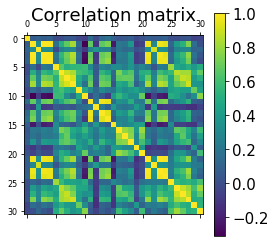

In [12]:
# Step 2. Analyze Data: May be better to view Correlation matrix 
plt.figure()
plt.rcParams.update({'font.size': 8})
plt.matshow(dataset.corr())
plt.rcParams['figure.figsize'] = (10,10)
plt.rcParams.update({'font.size': 15})
plt.title('Correlation matrix')
clb = plt.colorbar()
plt.show()

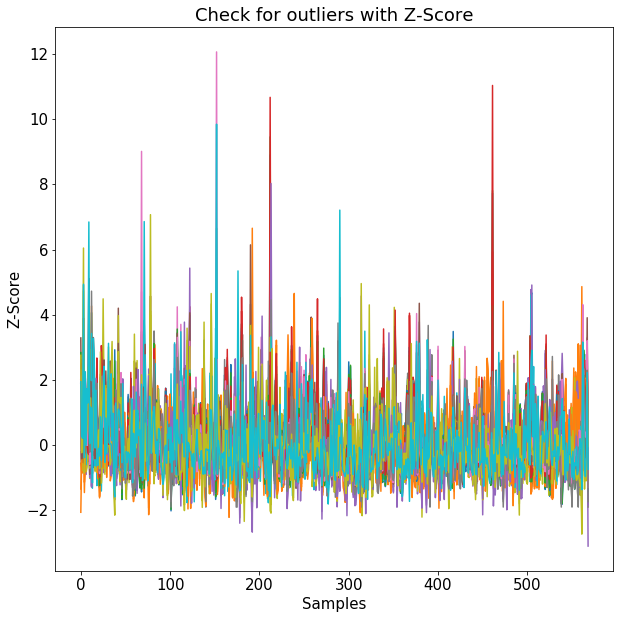

Outliers are usually values > 3 or < -3.


In [13]:
# Step 2. Analyze Data: descriptive statistics
# Check for outliers...
from scipy import stats
z = stats.zscore(dataset.iloc[:, 1:31].values)
plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
for i in range(30):
  plt.plot(z[:,i])
plt.rcParams.update({'font.size': 15})
plt.title('Check for outliers with Z-Score')
plt.xlabel("Samples")
plt.ylabel("Z-Score")
plt.show()
print("Outliers are usually values > 3 or < -3.")

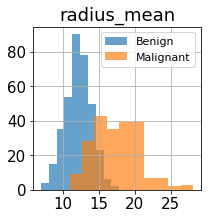

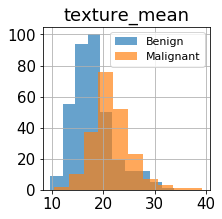

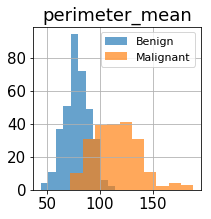

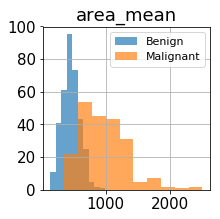

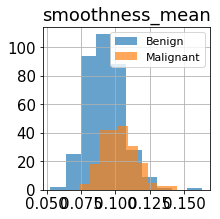

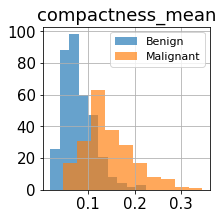

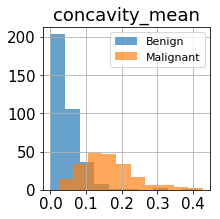

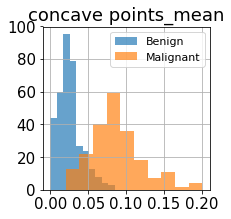

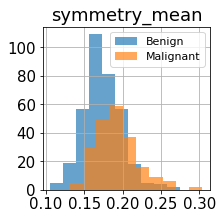

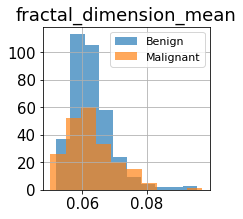

In [44]:
# Step 2. Analyze Data: visualization
# plot class distrubtion for each feature 
plt.rcParams["figure.figsize"] = (3,3)

for i in range(10):
  plt.figure()
  plt.rcParams.update({'font.size':15})
  plt.title(Bnames[i])
  dataset.groupby(('diagnosis'))[Bnames[i]].hist(alpha=0.68)
  plt.rcParams.update({'font.size':11})
  plt.gca().legend(('Benign','Malignant')) # I checked with np.where(dataset.diagnosis=='M')[0] for this labelling, below.

plt.show()


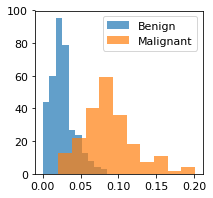

In [15]:
beni = np.where(dataset.diagnosis=='B')[0]

plt.hist(dataset['concave points_mean'][beni],alpha=0.7)

malig = np.where(dataset.diagnosis=='M')[0]
plt.hist(dataset['concave points_mean'][malig],alpha=0.7)

plt.gca().legend(('Benign','Malignant'))
plt.rcParams["figure.figsize"] = (4,4)
plt.show()

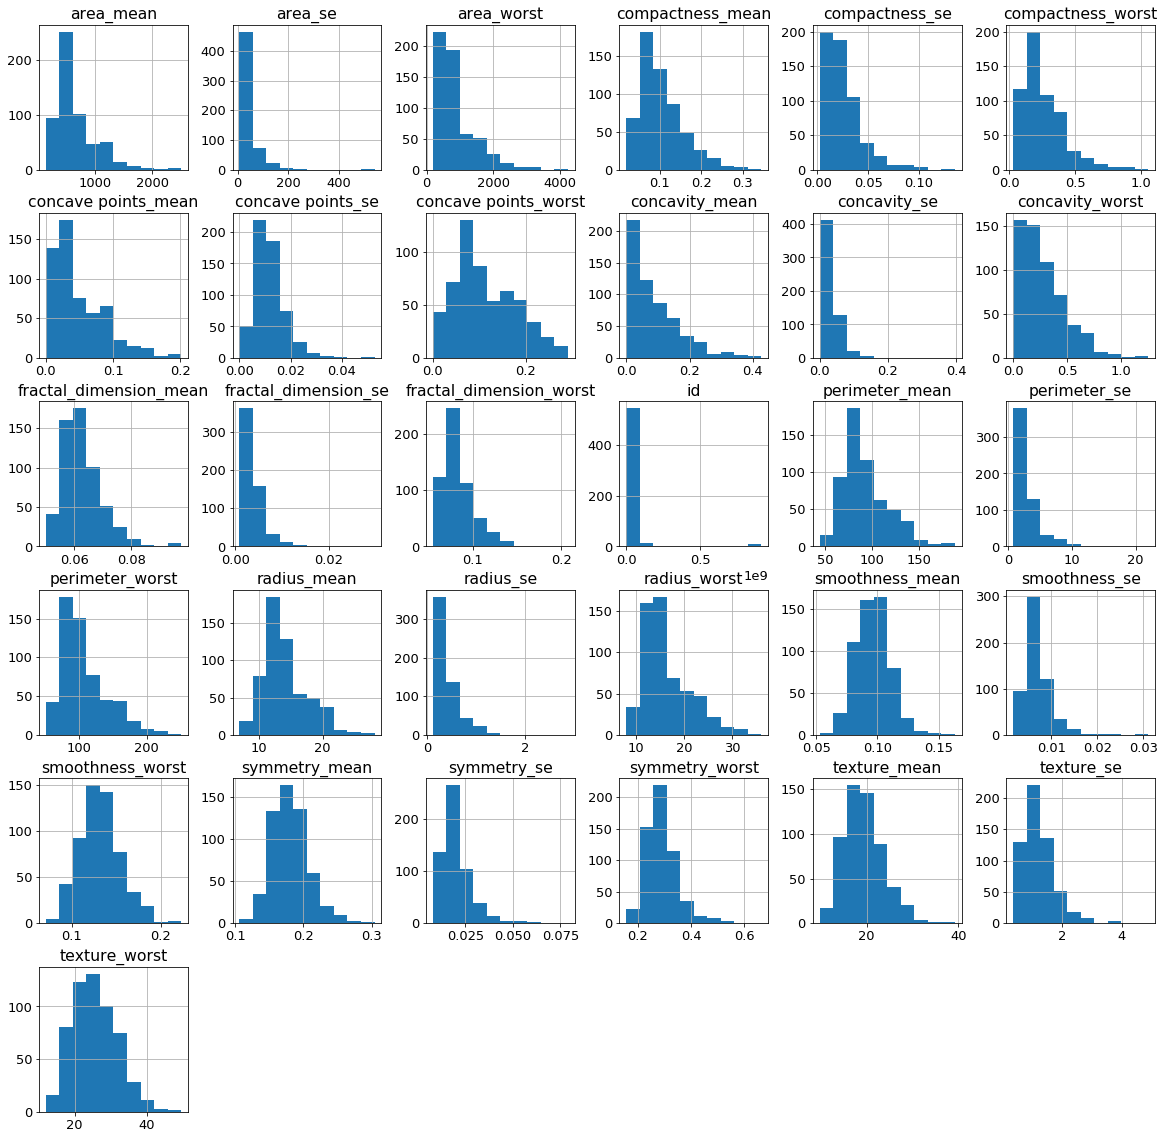

In [46]:
# Step 2. Analyze Data: visualization
dataset.hist()
plt.rcParams.update({'font.size':13})
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

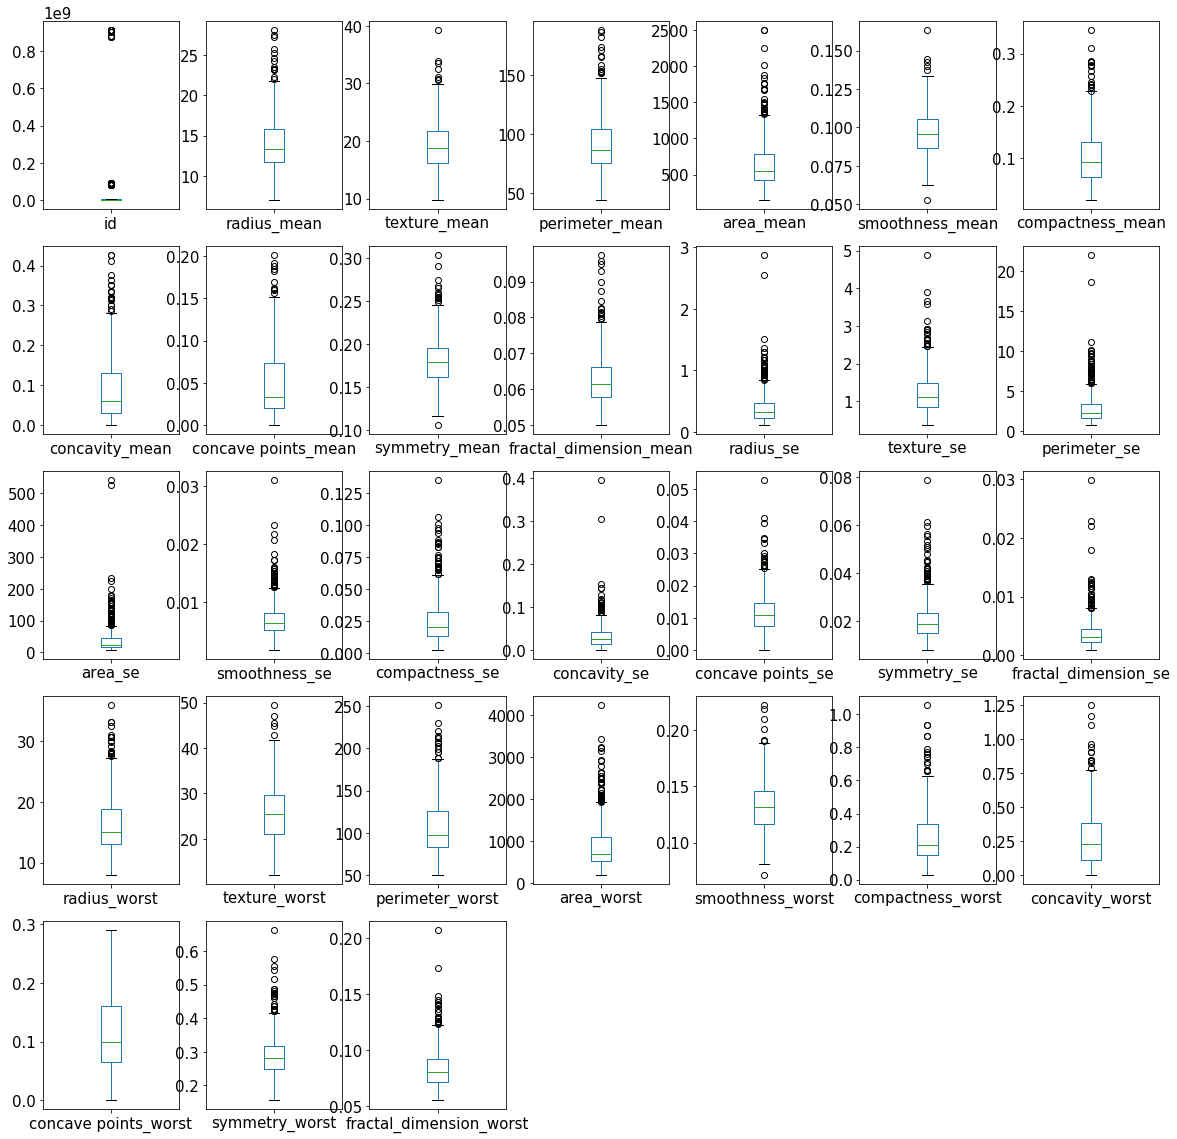

In [17]:
# Step 2. Analyze Data: visualization
plt.rcParams.update({'font.size': 15})
plt.ioff()
dataset.plot(kind='box', subplots=True, layout=(5,7), sharex=False, sharey=False) 
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

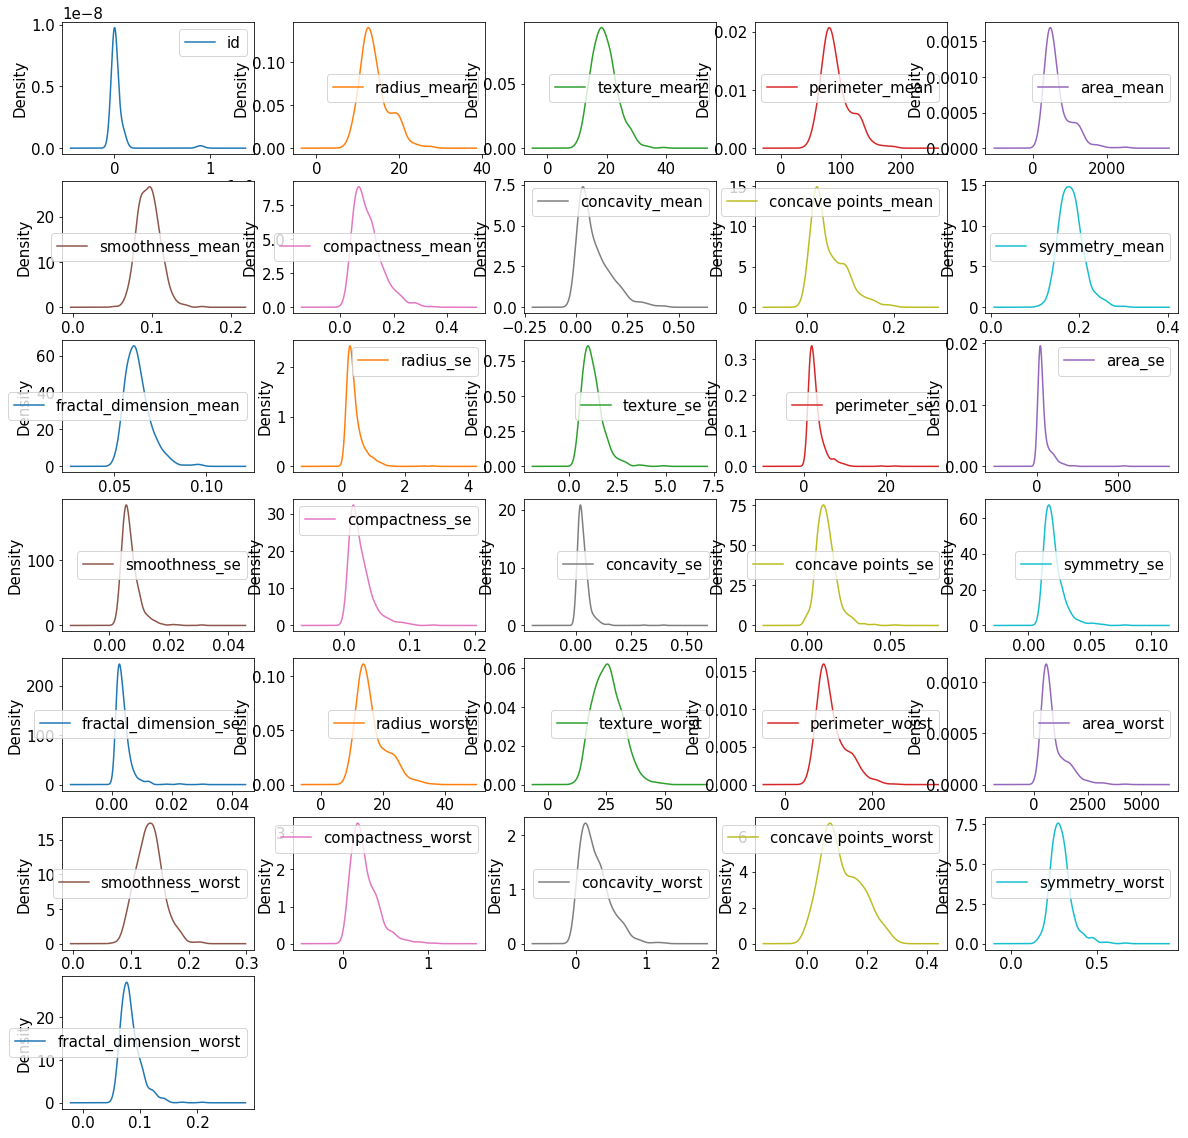

In [18]:
# Step 2. Analyze Data: visualization
plt.rcParams.update({'font.size':15})
dataset.plot(kind='density', subplots=True, layout=(7,5), sharex=False) 
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

In [19]:
# Step 2. Analyze Data: visualization
scatter = 'off'
if scatter == 'on':
    from pandas.plotting import scatter_matrix  
    plt.rcParams["figure.figsize"] = (20,20)
    scatter_matrix(dataset) 
    plt.show()

# Step 3. Prepare Data

In [20]:
#Step 3. Prepare Data: 
print("Check if we have as many rows of labels as training examples:")
X = dataset.iloc[:, 1:31].values    #Predictors / Features 
Y = dataset.iloc[:, 31].values      #Labels

print(X.shape)
print(Y.shape)
if X.shape[0] == Y.shape[0]: print("We do")

Check if we have as many rows of labels as training examples:
(569, 30)
(569,)
We do


In [21]:
#Step 3. Prepare Data: 
print("Encoding categorical data values")
print("This is what we have to begin with:")
#print(Y[0:20])
why = np.array(dataset.iloc[15:30,31]).reshape(1,-1)
print(why)

labelencoder_Y = LabelEncoder()
Y = labelencoder_Y.fit_transform(Y)
print("Can use LabelEncoder, but you can't control and which is 0 which is 1.")
print(np.array(Y[15:30]))

# dataset['diagnosis'] = dataset['diagnosis'].map({'M':1, 'B':0})

Encoding categorical data values
This is what we have to begin with:
[['M' 'M' 'M' 'M' 'B' 'B' 'B' 'M' 'M' 'M' 'M' 'M' 'M' 'M' 'M']]
Can use LabelEncoder, but you can't control and which is 0 which is 1.
[1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]


In [22]:
print("So let's use the results of np.where() from earlier, so we can be sure we get our labels and confusion matrix right.")
Y = np.empty(shape=(np.shape(dataset)[0],1)) 
Y[beni] = 0
Y[malig] = 1
print(Y[15:30].T)
# print(beni)

So let's use the results of np.where() from earlier, so we can be sure we get our labels and confusion matrix right.
[[1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]]
[ 19  20  21  37  46  48  49  50  51  52  55  58  59  60  61  63  66  67
  68  69  71  74  76  79  80  81  84  88  89  90  92  93  96  97  98 101
 102 103 104 106 107 109 110 111 112 113 114 115 116 120 123 124 125 128
 130 133 136 137 139 140 142 143 144 145 147 148 149 150 151 152 153 154
 155 157 158 159 160 163 165 166 169 170 173 174 175 176 178 179 183 185
 187 188 189 191 192 195 200 204 206 208 209 211 216 217 220 221 222 224
 225 226 227 228 231 232 234 235 238 240 241 242 243 245 246 247 248 249
 251 266 267 268 269 270 271 273 275 276 278 279 281 284 285 286 287 288
 289 290 291 292 293 294 295 296 298 299 301 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 318 319 320 322 324 325 326 327 331 332 333
 334 336 338 340 341 342 344 345 346 347 348 349 350 354 355 356 357 358
 359 360 361 362 363 364 367 37

In [23]:
#Step 3. Prepare Data: 
#train / validation spilt
from sklearn.model_selection import train_test_split
validation_size = 0.4
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size = validation_size, random_state = 0, stratify=Y)


214
127


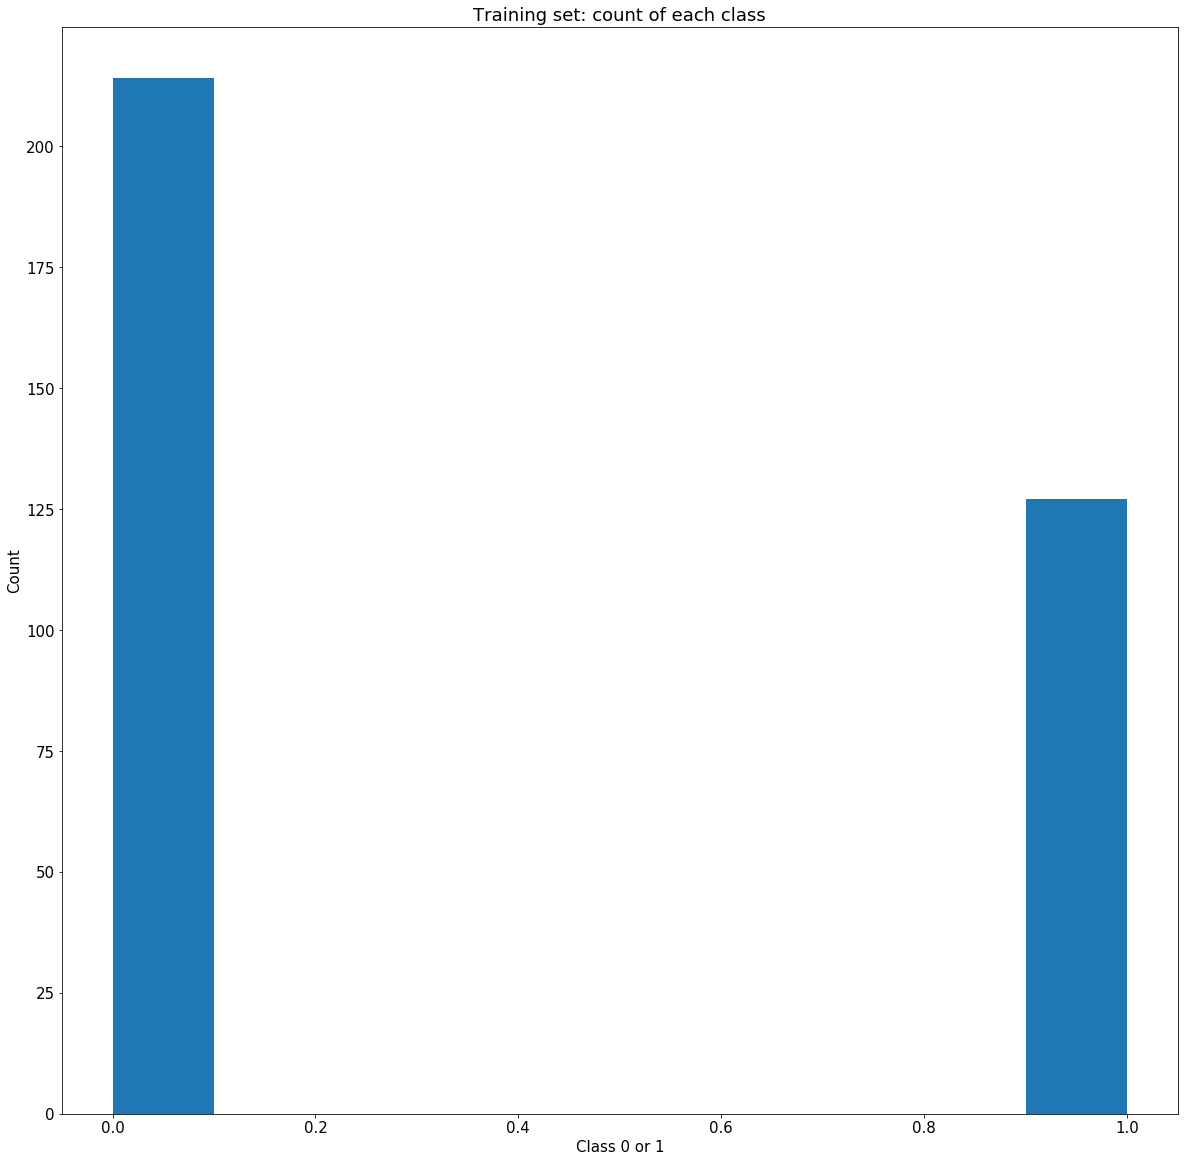

Class imbalance = 59.3%


In [24]:
#Step 3. Prepare Data: (on training data only)
# check spilt is as expected 
# print(class_counts[0] * (1-validation_size))
# print(class_counts[1] * (1-validation_size))
lenY0 = len(Y_train[Y_train==0])
lenY1 = len(Y_train[Y_train==1])
print(lenY0)
print(lenY1)
plt.hist( Y_train, bins='auto')
plt.title("Training set: count of each class")
plt.xlabel("Class 0 or 1")
plt.ylabel("Count")
plt.show()
print("Class imbalance = "+str(round(lenY1/lenY0*100,1) )+ "%" )

143
85


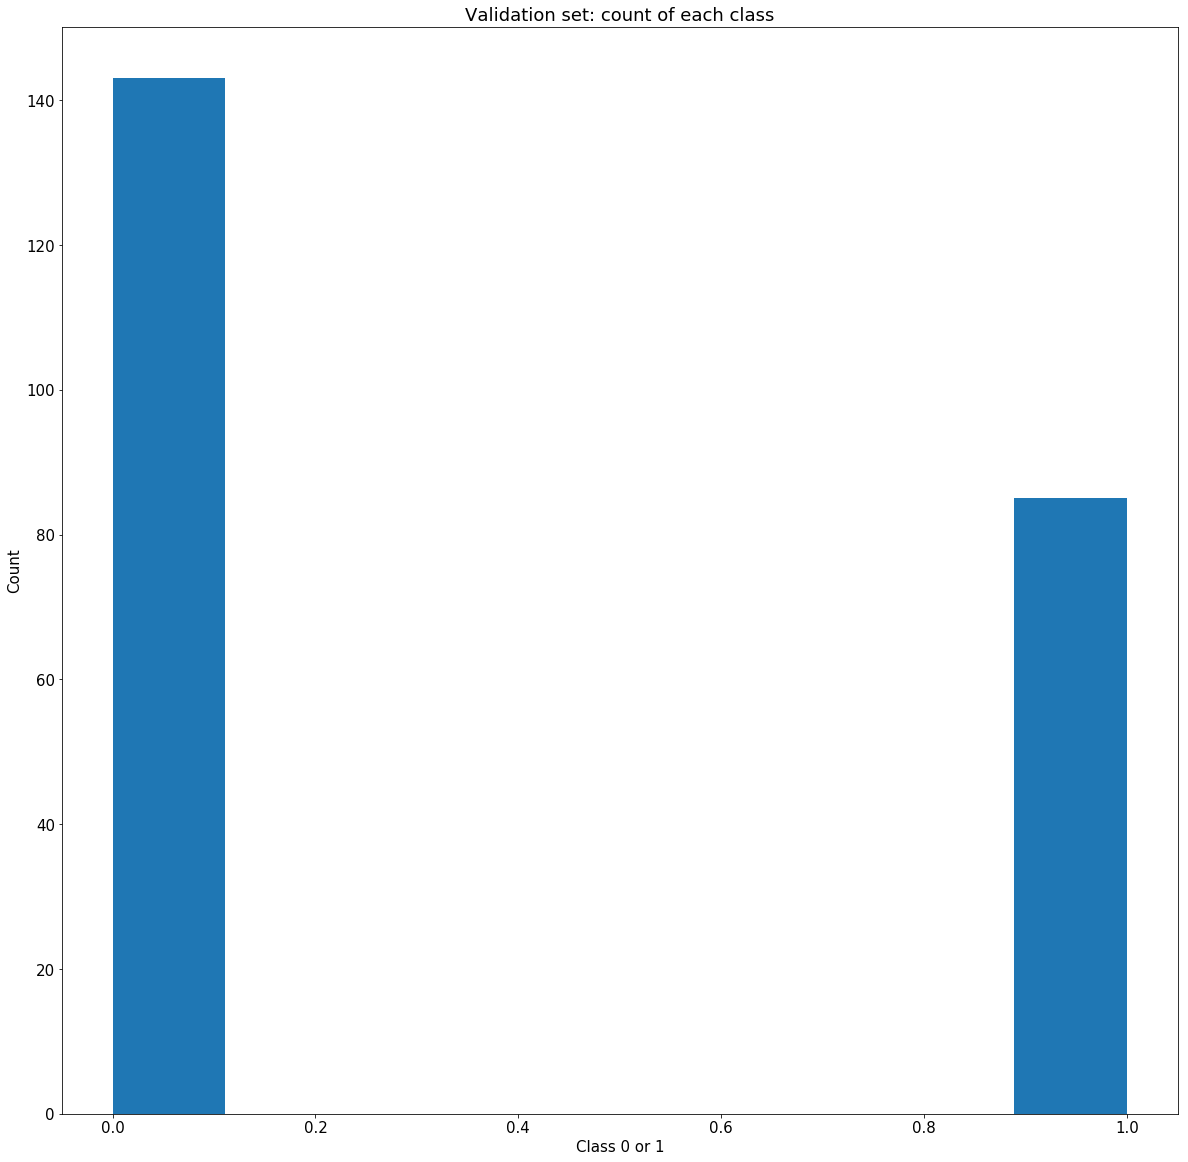

Class imbalance = 59.4%


In [25]:
#Step 3. Prepare Data: (on training data only) 
# check spilt is as expected 
# print(class_counts[0] * (validation_size))
# print(class_counts[1] * (validation_size))
lenY0 = len(Y_validation[Y_validation==0])
lenY1 = len(Y_validation[Y_validation==1])
print(lenY0)
print(lenY1)
plt.hist( Y_validation, bins='auto')
plt.title("Validation set: count of each class")
plt.xlabel("Class 0 or 1")
plt.ylabel("Count")
plt.show()
print("Class imbalance = "+str(round(lenY1/lenY0*100,1) )+ "%" )

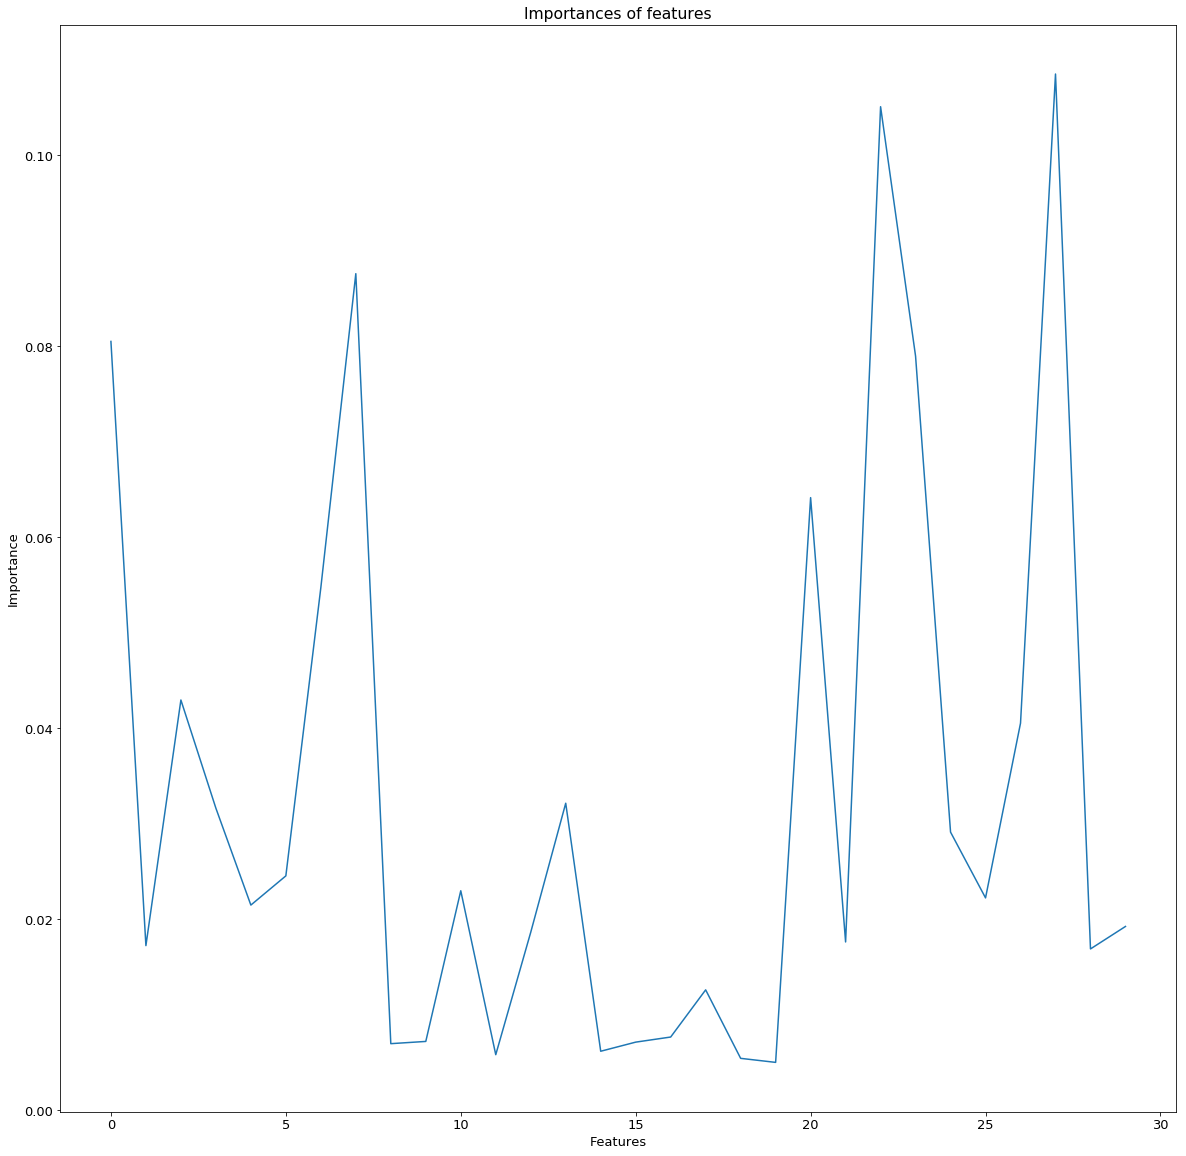

Features least important..
[19 18 11 14  8 15  9 16 17 28  1 21 12 29  4 25 10  5 24  3 13 26  2  6
 20 23  0  7 22 27]
to most important
If you re-run it, you'll see the order changes, but only a little. The big players are always the big players.


In [49]:
#Step 3. Prepare Data: (on training data only)
#Feature Selection (on training data)


# fit an Extra Trees model to the data
model = ExtraTreesClassifier(n_estimators=100)
model.fit(X_train,Y_train.reshape(Y_train.shape[0]))

plt.plot(model.feature_importances_)
plt.title("Importances of features")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

ind = np.argsort(model.feature_importances_,axis=0)
print("Features least important..")
print(ind)
print("to most important")
print("If you re-run it, you'll see the order changes, but only a little. The big players are always the big players.")




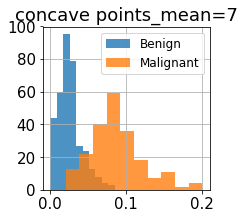

In [27]:

# plot class distrubtion for each feature 
plt.rcParams["figure.figsize"] = (3,3)
for i in range(7,8):
  plt.figure()
  plt.title(Bnames[i] +"="+ str( i))
  dataset.groupby(('diagnosis'))[Bnames[i]].hist(alpha=0.8)
  plt.rcParams.update({"font.size":12})
  plt.gca().legend(('Benign','Malignant'))

plt.show()


In [28]:
np.shape(X_train)

(341, 30)

In [29]:
np.shape(Y_train) 
Y_train = Y_train.reshape(Y_train.shape[0]) # if warning about shape, use Y_train.reshape... as done here

Shape V
(341, 30)


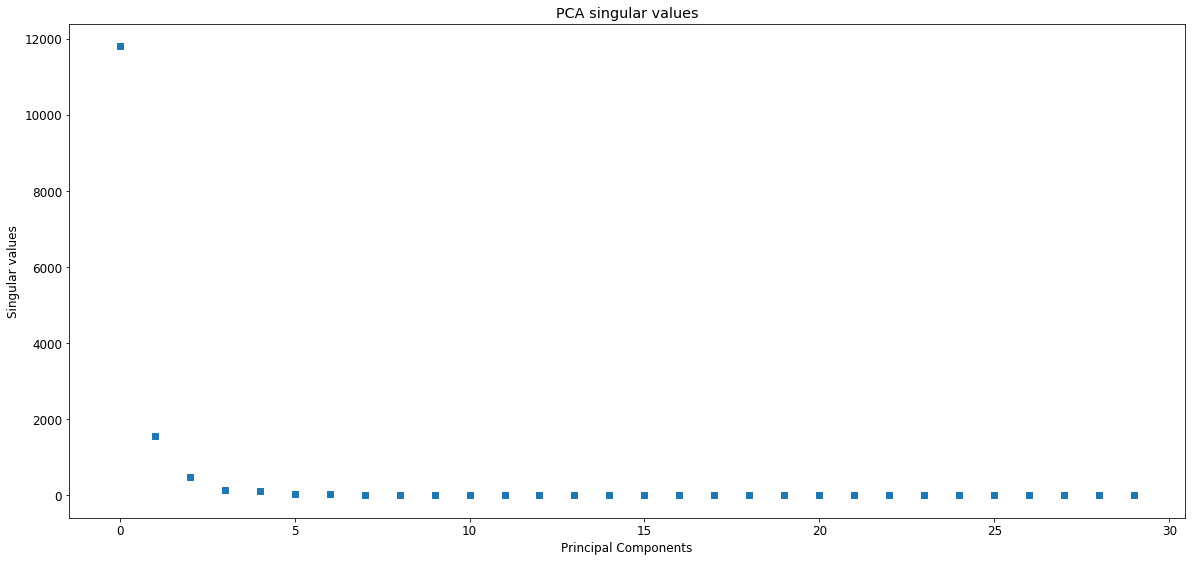

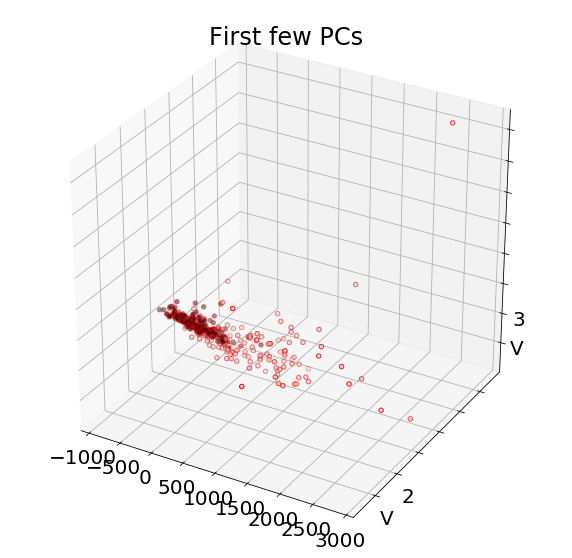

In [30]:
#Step 3. Prepare Data: (on training data only)
#Check PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (20,20)
pca = PCA()
pca.fit(X_train) # Re-running this causes trouble, once you've transformed X_train  
V = pca.transform(X_train)
print("Shape V")
print(np.shape(V))

plt.figure()
plt.subplot(211)
plt.plot(pca.singular_values_,'s') 
plt.xlabel('singular_values')
plt.title("PCA singular values")
plt.xlabel("Principal Components")
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size':20})
plt.ylabel("Singular values")
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(V[:, 0], V[:, 1], V[:, 2], c=Y_train, cmap=plt.cm.nipy_spectral, # 
ax.scatter(V[:, 0], V[:, 1], V[:, 2], c=Y_train, cmap=plt.cm.nipy_spectral, # 

        # ax.scatter(V[0,:], V[1,:], V[2,:], c=Y_train, cmap=plt.cm.nipy_spectral,
           edgecolor='r')

ax.w_yaxis.set_ticklabels('V1')
ax.w_yaxis.set_ticklabels('V2')
ax.w_zaxis.set_ticklabels('V3')
plt.rcParams["figure.figsize"] = (3,3)
plt.title("First few PCs")
plt.show()


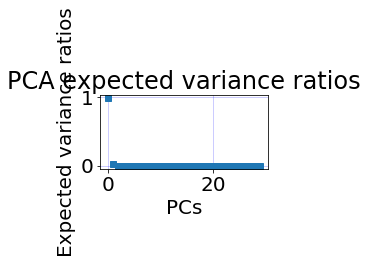

In [31]:
plt.figure()
plt.subplot(211)
plt.plot(pca.explained_variance_ratio_,'s') 
plt.grid(color='b', linestyle='-', linewidth=1, alpha=0.2)
plt.title("PCA expected variance ratios")
plt.xlabel("PCs")
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size':20})
plt.ylabel("Expected variance ratios")
plt.show()

# Step 4. Evaluate Algorithms (on training data only)

LR: 0.995486 (0.008259)
LDA: 0.993425 (0.007487)
QDA: 0.988072 (0.009749)
KNN: 0.985425 (0.020742)
CART: 0.927454 (0.042338)
NB: 0.987370 (0.014992)
SVMRBF: 0.996597 (0.005994)
SVM: 0.994722 (0.008807)
MLP: 0.995972 (0.007262)


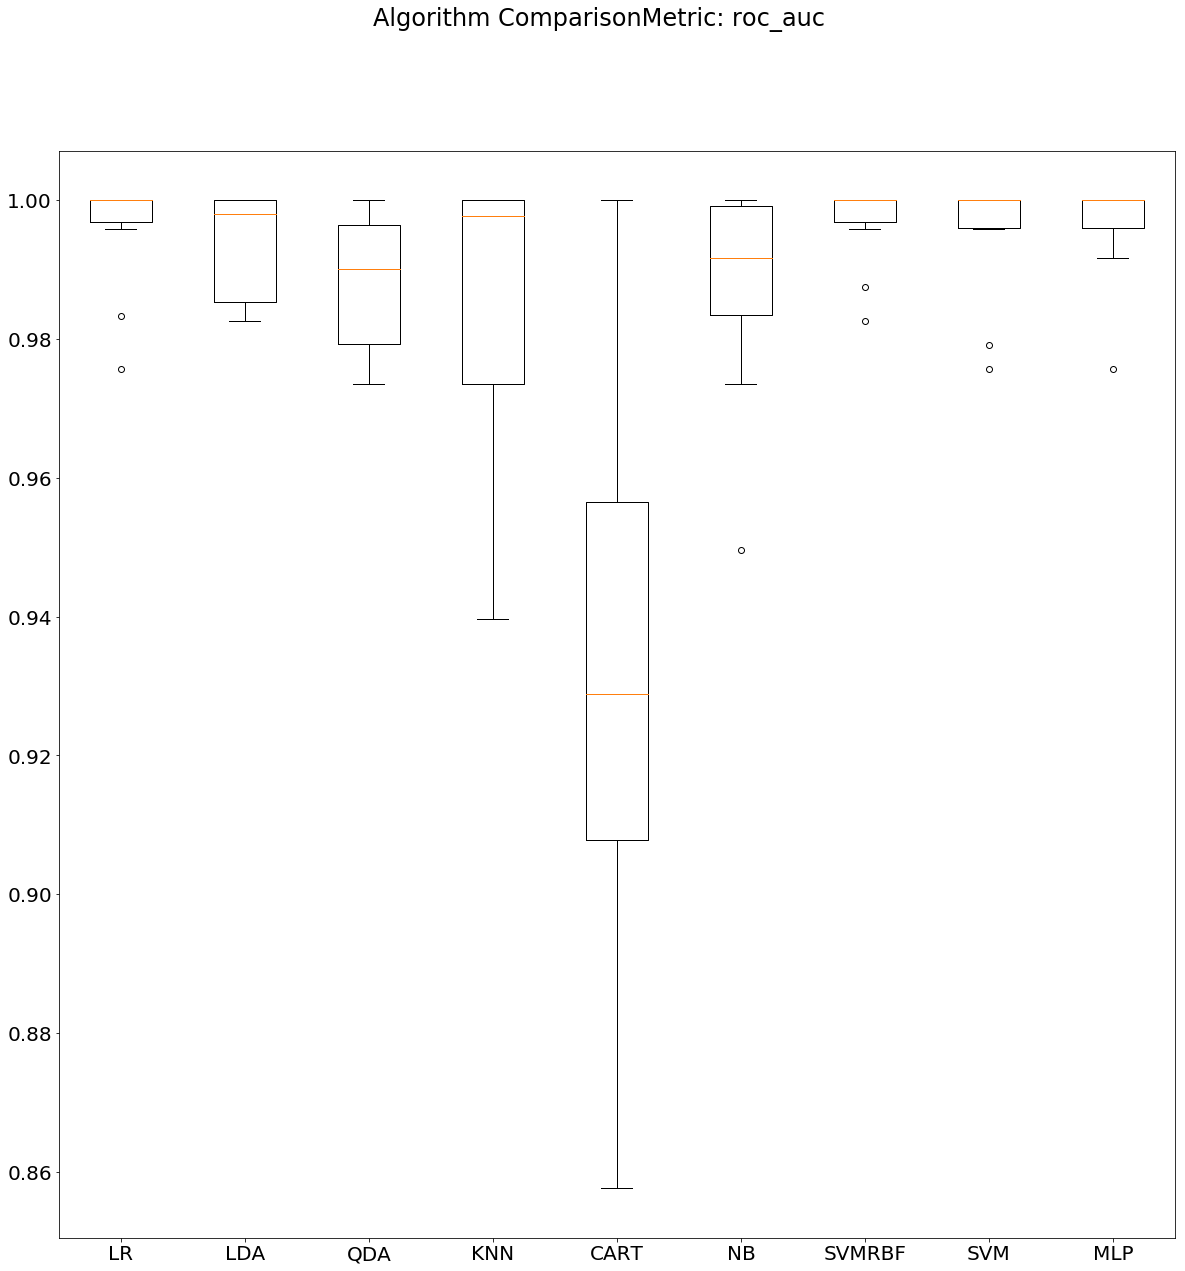

LR: 0.970672 (0.018603)
LDA: 0.947227 (0.028788)
QDA: 0.947227 (0.025607)
KNN: 0.967647 (0.020588)
CART: 0.932521 (0.039610)
NB: 0.944286 (0.024416)
SVMRBF: 0.976471 (0.017647)
SVM: 0.979412 (0.022971)
MLP: 0.982353 (0.019510)


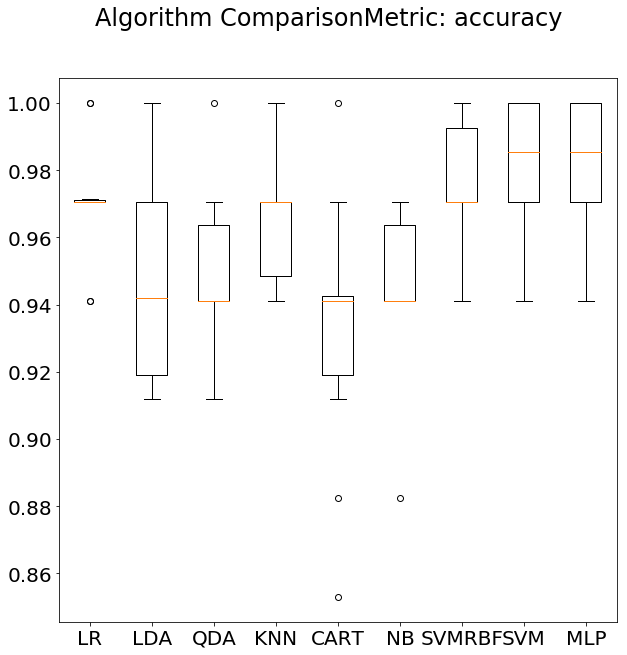

In [32]:
#Step 4. Evaluate Algorithms (on training data only)
# Using Feature Importances.
seed = 7
flagPrep = True

if flagPrep ==  True:
  #Data Reduction
  n=5
  index = ind[-20:] # Of the feature importance incides, take the last 20, a.k.a. the most important.
  X_Red = X_train[:,index]  
  #X_Red = n_features
  #transform the data
  scaler = StandardScaler()
  scaler.fit(X_Red)
  X_train_Transformed = scaler.transform(X_Red)
else: 
  X_train_Transformed = X_train

# prepare models
models = []
models.append(('LR', LogisticRegression(solver = 'lbfgs',max_iter=2500,class_weight='balanced')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(class_weight='balanced')))
models.append(('NB', GaussianNB()))
models.append(('SVMRBF', SVC(kernel='rbf',gamma='auto',class_weight='balanced')))
models.append(('SVM', SVC(kernel='linear',gamma='auto',class_weight='balanced')))
models.append(('MLP',MLPClassifier(hidden_layer_sizes = 15, alpha=1, max_iter=750)))

for i in range(2):
# evaluate each model in turn
    results = []
    names = []
    if i == 0:
      scoringmetric = 'roc_auc'
    else:
      scoringmetric = 'accuracy'
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model,X_train_Transformed , Y_train, cv=kfold, scoring=scoringmetric)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (10,10)
    fig.suptitle('Algorithm Comparison' + str ('Metric: ') + str(scoringmetric))
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

# Step 5. Improve Results (on training data only)

In [33]:
#Step 5. Improve Results  - (on training data only)
#create a pipeline
estimators = [] 
estimators.append(('standardize', StandardScaler())) 
estimators.append(('pca', PCA()))
estimators.append(('logistic', LogisticRegression(class_weight = 'balanced',solver='lbfgs',max_iter=2000)))

#we need to determine the number of features that we should use from PCA
#we need to determine the regularisation paarmeter in logisitic regression to avoid overfitting
param_grid = {
    'pca__n_components': [2,3,4,5,6,7,8,9,10],
    'logistic__C': [10,5,1,0.1,0.01,0.001]
}

modelHPS = Pipeline(estimators) # evaluate pipeline

In [34]:
#Step 5. Improve Results-  (on training data only)
#HyperParameter Selection
search = GridSearchCV(modelHPS, param_grid, iid=False, cv=10,return_train_score=False,scoring='roc_auc')
search.fit(X_train,Y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.996):
{'logistic__C': 1, 'pca__n_components': 8}


In [35]:
#Step 5. Improve Results  - (on training data only)
print('Best Model Parameters')
print('intercept is',search.best_estimator_.named_steps['logistic'].intercept_)
print('coefficients are',search.best_estimator_.named_steps['logistic'].coef_)

Best Model Parameters
intercept is [0.30845377]
coefficients are [[ 2.42342902 -1.17485205 -0.39321808  0.17581396 -1.34314259 -0.49525419
   0.28999721  1.04825919]]


In [36]:
#Step 5. Present Results: (on training data only)
#CV for best model on training data only
from sklearn.model_selection import cross_val_predict,StratifiedKFold
n_repeats = 10
best_pipeline = search.best_estimator_
threshold = 0.1 # could try 0.001, 0.3 and see how the metrics change: sens, spec, NPV, AUC.

auc_cv = np.zeros(n_repeats)
sen_cv = np.zeros(n_repeats)
spe_cv = np.zeros(n_repeats)
npv_cv = np.zeros(n_repeats)

for i in range(n_repeats):
    y_pred_cv = np.zeros(Y_train.shape)
    y_proba_cv  = cross_val_predict(best_pipeline,X_train,Y_train,cv=StratifiedKFold(3, shuffle=True),method = "predict_proba")
    y_proba_cv = y_proba_cv[:,1]
    y_pred_cv[y_proba_cv > threshold] = 1.0
    fpr_cv, tpr_cv, thresholds_cv = roc_curve(Y_train, y_proba_cv)
    auc_cv[i] = roc_auc_score(Y_train, y_proba_cv)
    tn_cv,fp_cv,fn_cv,tp_cv = confusion_matrix(Y_train,y_pred_cv).ravel()
    sen_cv[i] = tp_cv / (tp_cv + fn_cv)
    spe_cv[i] = tn_cv / (tn_cv + fp_cv)
    npv_cv[i] = tn_cv / (tn_cv + fn_cv)
    
print("sensitivity %0.3f (+/- %0.01g)" % (sen_cv.mean(),1.96 * sen_cv.std() / np.sqrt(n_repeats)))
print("specificity %0.3f (+/- %0.01g)" % (spe_cv.mean(),1.96 * spe_cv.std() / np.sqrt(n_repeats)))
print("NPV %0.3f (+/- %0.01g)" % (npv_cv.mean(),1.96 * npv_cv.std() / np.sqrt(n_repeats)))
print("AUC %0.4f (+/- %0.01g)" % (auc_cv.mean(),1.96 * auc_cv.std() / np.sqrt(n_repeats)))
# using %0.01g rounds to 1 significant figure.
# using %0.3f rounds to 3 decimal places

sensitivity 0.988 (+/- 0.003)
specificity 0.865 (+/- 0.004)
NPV 0.992 (+/- 0.002)
AUC 0.9938 (+/- 0.001)


# Step 6. Present Results: training data and apply to validation data)

In [37]:
#Step 6. Present Results: (build using training data only and apply to validation data)
#prepare final model and apply to validation data


method = 1
if method == 1:
    #finalise the model
    preprocess_pipeline = make_pipeline(StandardScaler(), PCA(n_components=search.best_params_['pca__n_components']))
    #prepare the data (train and validation)
    preprocess_pipeline.fit(X_train)
    X_train_transformed = preprocess_pipeline.transform(X_train)
    X_validation_transformed = preprocess_pipeline.transform(X_validation)
    #fit to the whole data
    model = LogisticRegression(class_weight = 'balanced',solver='lbfgs',max_iter=1000,C = search.best_params_['logistic__C'] )
    model.fit(X_train_transformed,Y_train)
    predictions = model.predict(X_validation_transformed)
    probs = model.predict_proba(X_validation_transformed)
    probsx = probs[:,1]
    print('Best Model Parameters and fitting to the final data')
    print('intercept is',model.intercept_)
    print('coefficients are',model.coef_)
elif method == 2:
    #alternative way
    p_clf = make_pipeline(StandardScaler(), PCA(n_components=search.best_params_['pca__n_components']), 
                            LogisticRegression(class_weight = 'balanced',solver='lbfgs',max_iter=1000,C = search.best_params_['logistic__C'] ))
    p_clf.fit(X_train, Y_train) 
    predictions = p_clf.predict(X_validation)
    probs = p_clf.predict_proba(X_validation)
    probsx =probs[:,1]
else:
    p_clf = make_pipeline(best_pipeline)
    p_clf.fit(X_train, Y_train) 
    predictions = p_clf.predict(X_validation)
    probs = p_clf.predict_proba(X_validation)
    probsx = probs[:,1]



Best Model Parameters and fitting to the final data
intercept is [0.30845377]
coefficients are [[ 2.42342902 -1.17485205 -0.39321808  0.17581396 -1.34314259 -0.49525419
   0.28999721  1.04825919]]


In [38]:
#Step 6. Present Results: (validation data)
# Sensitivity_and_specificity assuming a threshold on validation data

fpr, tpr, thresholds = roc_curve(Y_validation, probsx)
threshold = 0.1
y_pred = np.zeros(probsx.shape)
y_pred[probsx > threshold] = 1
tn,fp,fn,tp = confusion_matrix(Y_validation,y_pred).ravel()
sen = tp / (tp+fn)
spec = tn / (tn+fp)
npv = tn / (tn + fn)
# calculate AUC
auc = roc_auc_score(Y_validation, probsx)
print("AUC {}". format(auc))
print("Cut-off {}". format(threshold))
print("NPV: %0.3f" %(npv))
print("sensivity: %0.3f" %(sen))
print("specfivity: %0.3f" %(spec))

AUC 0.9927601809954751
Cut-off 0.1
NPV: 0.984
sensivity: 0.976
specfivity: 0.853


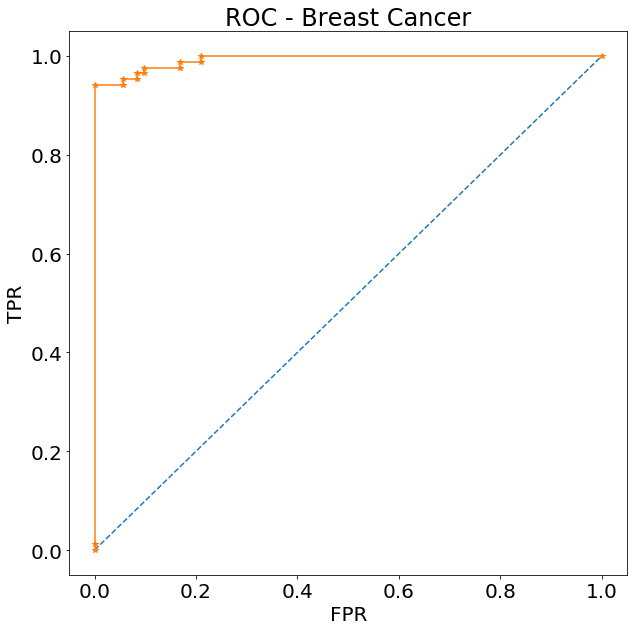

In [39]:
#Step 6. Present Results:  (validation data)
#plot ROC
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='*')
# show the plot
plt.xlabelauc = roc_auc_score(Y_validation, probsx)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC - Breast Cancer')
plt.show()


In [40]:
#Step 6. Present Results:  (validation data)
#check the results
print('The accuracy score is')
print(accuracy_score(Y_validation, predictions))
print('The confusion matrix is')
print(confusion_matrix(Y_validation, predictions))
print('The classification report is')
print(classification_report(Y_validation, predictions))
#help(classification_report)

The accuracy score is
0.9385964912280702
The confusion matrix is
[[133  10]
 [  4  81]]
The classification report is
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       143
         1.0       0.89      0.95      0.92        85

   micro avg       0.94      0.94      0.94       228
   macro avg       0.93      0.94      0.94       228
weighted avg       0.94      0.94      0.94       228



 The reported averages include micro average (averaging the
        total true positives, false negatives and false positives), macro
        average (averaging the unweighted mean per label), weighted average
        (averaging the support-weighted mean per label) and sample average
        (only for multilabel classification).

## Thank you, enjoy.

# BONUS - Missing Values

In [41]:
#Step 3. #importing our cancer dataset and addressing missing values (use pandas)
dataset1 = pd.read_csv('dataMissingValues.csv')
print(dataset1.head(1))

# check for missing / null points
nullCount = dataset1.isnull().sum()
print(nullCount)
if sum(nullCount) > 0:
 print("\nWe have "+ str(sum(nullCount)) + " null values.")

       id  radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0  842302        17.99         10.38           122.8     1001.0             0.12   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  ...  texture_worst  \
0              0.28             0.3                 0.15           0.24  ...          17.33   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0            184.6      2019.0              0.16               0.67             0.71   

   concave points_worst  symmetry_worst  fractal_dimension_worst  diagnosis  
0                  0.27            0.46                      NaN          M  

[1 rows x 32 columns]
id                         0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean          

In [42]:
#Step 3. Prepare Data: 
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(dataset.iloc[:, 1:31].values)
X1 = imp.transform(dataset.iloc[:, 1:31].values) 
print(X1[0,:])
print(pd.DataFrame(X1).isnull().sum())
print("After imputation,  we have "+ str(sum(pd.DataFrame(X1).isnull().sum())) + " null values.")

[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
 4.601e-01 1.189e-01]
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
dtype: int64
After imputation,  we have 0 null values.
